In [1]:
import tensorflow as tf

keras = tf.keras
tf.__version__

'2.5.0'

In [2]:
import sys
sys.version

'3.9.6 (default, Jun 29 2021, 05:25:02) \n[Clang 12.0.5 (clang-1205.0.22.9)]'

In [3]:
# This is just as the reference for the structure of the h5 model trained on the server
"""
pretrained_model = keras.applications.Xception(
    include_top = False
)
pretrained_model.trainable = False
    
model = keras.Sequential([
    keras.layers.InputLayer(input_shape = [None, None, 3]),
    keras.layers.experimental.preprocessing.Resizing(299, 299),
    keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1),
    pretrained_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(len(class_names))
])
"""

'\npretrained_model = keras.applications.Xception(\n    include_top = False\n)\npretrained_model.trainable = False\n    \nmodel = keras.Sequential([\n    keras.layers.InputLayer(input_shape = [None, None, 3]),\n    keras.layers.experimental.preprocessing.Resizing(299, 299),\n    keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1),\n    pretrained_model,\n    keras.layers.GlobalAveragePooling2D(),\n    keras.layers.Dense(len(class_names))\n])\n'

# Load from h5 File

In [4]:
model_path = './tf-flower-photo-tfrec.h5'
model = keras.models.load_model(model_path)
model

In [5]:
import PIL 
import requests
import io

# https://en.wikipedia.org/wiki/Lilium_bulbiferum
flower_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9a/Lilium_bulbiferum_var._bulbiferum_01.JPG/576px-Lilium_bulbiferum_var._bulbiferum_01.JPG'
response = requests.get(flower_url)
img = PIL.Image.open(
    io.BytesIO(response.content)
)

In [6]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [7]:
image = tf.keras.preprocessing.image.img_to_array(img).astype(int)

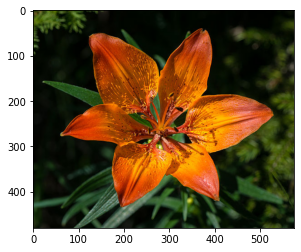

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [9]:
import numpy as np
predicted = model.predict(np.array([image]))[0]

In [10]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
arr = tf.nn.softmax(predicted).numpy()

In [11]:
def get_top_k(arr, k = 5):
    return arr.argsort()[-k:][::-1]
print(get_top_k(arr))
arr[get_top_k(arr)]

[  5 101  20  45  17]


array([9.9921584e-01, 4.5422450e-04, 3.1280855e-04, 1.3330260e-05,
       1.1016223e-06], dtype=float32)

In [12]:
class_names = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium', # 0-4
    'tiger lily', 'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
          'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'
]

In [13]:
np.array(class_names)[get_top_k(arr)]

array(['tiger lily', 'blackberry lily', 'fire lily', 'wallflower',
       'peruvian lily'], dtype='<U25')

In [14]:
type(get_top_k(arr))

numpy.ndarray

In [15]:
def get_top_k_from_logits(prediction, k):
    arr = tf.nn.softmax(predicted).numpy()
    return np.array(class_names)[get_top_k(arr, k = k)]

get_top_k_from_logits(predicted, 3)

array(['tiger lily', 'blackberry lily', 'fire lily'], dtype='<U25')

# Create the TFLite Model

In [16]:
# keras_model = keras.models.load_model(model_path)
keras_model = model
# https://www.tensorflow.org/api_docs/python/tf/lite/TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: /var/folders/n5/cdj4lgpx26g66_jkwm8dd3340000gn/T/tmp80rrcnz9/assets


In [17]:
import pathlib

tflite_model_path = 'tf-flower-photo-tfrec-full.tflite'
tflite_model_file = pathlib.Path(tflite_model_path)
tflite_model_file.write_bytes(tflite_model)

83731400

# Evaluation on the TFLite Model

In [18]:
print(image.dtype)
print(image.shape)
(1, ) + image.shape

int64
(480, 576, 3)


(1, 480, 576, 3)

In [19]:
interpreter = tf.lite.Interpreter(model_content = tflite_model)
input_details = interpreter.get_input_details()
print(input_details)
print(input_details[0]['shape'])

# https://stackoverflow.com/questions/55701663/input-images-with-dynamic-dimensions-in-tensorflow-lite
input_index = interpreter.get_input_details()[0]['index']
print(input_index)
# Since we train the original model as [batch_size, None, None, 3(channel size)], we need to resize for tf lite to work
interpreter.resize_tensor_input(
    input_index, (1, ) + image.shape
)
interpreter.allocate_tensors()
print(input_details[0]['shape'])

[{'name': 'input_14', 'index': 0, 'shape': array([1, 1, 1, 3], dtype=int32), 'shape_signature': array([-1, -1, -1,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[1 1 1 3]
0
[1 1 1 3]


In [20]:
output_details = interpreter.get_output_details()
print(output_details)
output_index = interpreter.get_output_details()[0]['index']
print(output_index)
print(output_details[0]['shape'])

[{'name': 'Identity', 'index': 231, 'shape': array([  1, 104], dtype=int32), 'shape_signature': array([ -1, 104], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
231
[  1 104]


In [21]:
input_data = np.array([image.astype(np.float32)])
input_data.shape

(1, 480, 576, 3)

In [22]:
interpreter.set_tensor(input_index, input_data)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

In [23]:
get_top_k_from_logits(predicted[0], 3)

array(['tiger lily', 'blackberry lily', 'fire lily'], dtype='<U25')

# Reference

[UD190 - Introduction to TensorFlow Lite](https://www.udacity.com/course/intro-to-tensorflow-lite--ud190)

* Lession 2 
  * 11. Colab: Linear Regression
  * 12. Colab: Transfer Learning      
        